# Base de Dados

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## CICDDoS2019

### Downsample [Personalizado] 

In [33]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'
DOWNSAMPLE_FACTORS = {
    'TFTP': 0.0001,  # Redução mais agressiva 
    'MSSQL': 0.0001,
    'syn': 0.0001,
    'Default': 0.001  
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11_Test.csv',
    '01-12': 'CICDDoS2019_01_12_Train.csv'
}

In [ ]:
def processar_e_salvar_dia(dia, dataset_path, chunk_size, cols_to_drop, attack_order, output_files):
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Limpeza de Colunas
                cols_existentes_drop = [col for col in cols_to_drop if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                df_chunk[ATTACK_LABEL_COL] = df_chunk[ATTACK_LABEL_COL].apply(
                    lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                )
                
                df_benign = df_chunk[df_chunk[ATTACK_LABEL_COL] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[ATTACK_LABEL_COL] != BENIGN_LABEL]

                # Downsampling Seletivo nos Ataques
                df_ataque_downsampled = df_ataque

                if not df_ataque.empty:
                    # Fator de Downsample específico
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    # Se o número de amostras for MENOR que o mínimo, não fazemos Downsample (mantemos 100%)
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque_downsampled = df_ataque.sample(
                            frac=factor, 
                            random_state=42
                        )

                # Combina (BENIGN 100% + Ataque Reduzido) e Embaralha
                df_chunk_reduzido = pd.concat([df_benign, df_ataque_downsampled]).sample(frac=1, random_state=42)
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento do Chunk Imediato
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
dia_0311 = processar_e_salvar_dia(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

Dataset de Teste salvo: CICDDoS2019_03_11_Test.csv (Total: 72,083 amostras)
Dataset de Treino salvo: CICDDoS2019_01_12_Train.csv (Total: 88,803 amostras)


In [ ]:
dia_0112 = processar_e_salvar_dia(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

### Verificação da Base de dados gerada

Label
BENIGN           56863
DrDoS_SNMP        5161
DrDoS_DNS         5072
DrDoS_MSSQL       4523
DrDoS_NetBIOS     4094
DrDoS_UDP         3136
DrDoS_SSDP        2611
DrDoS_LDAP        2181
TFTP              2009
Syn               1583
DrDoS_NTP         1203
UDPLag             367
Name: count, dtype: int64


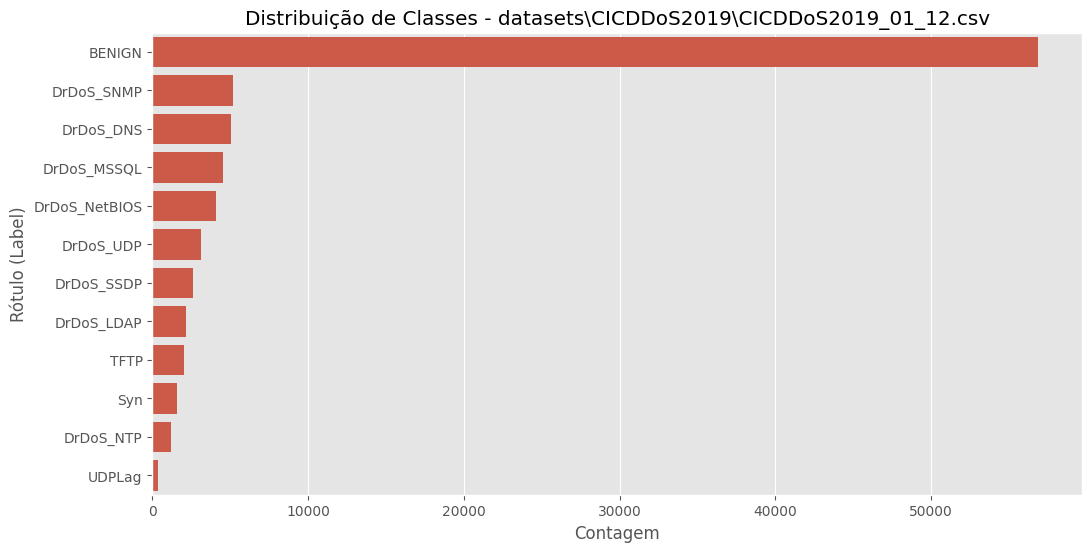

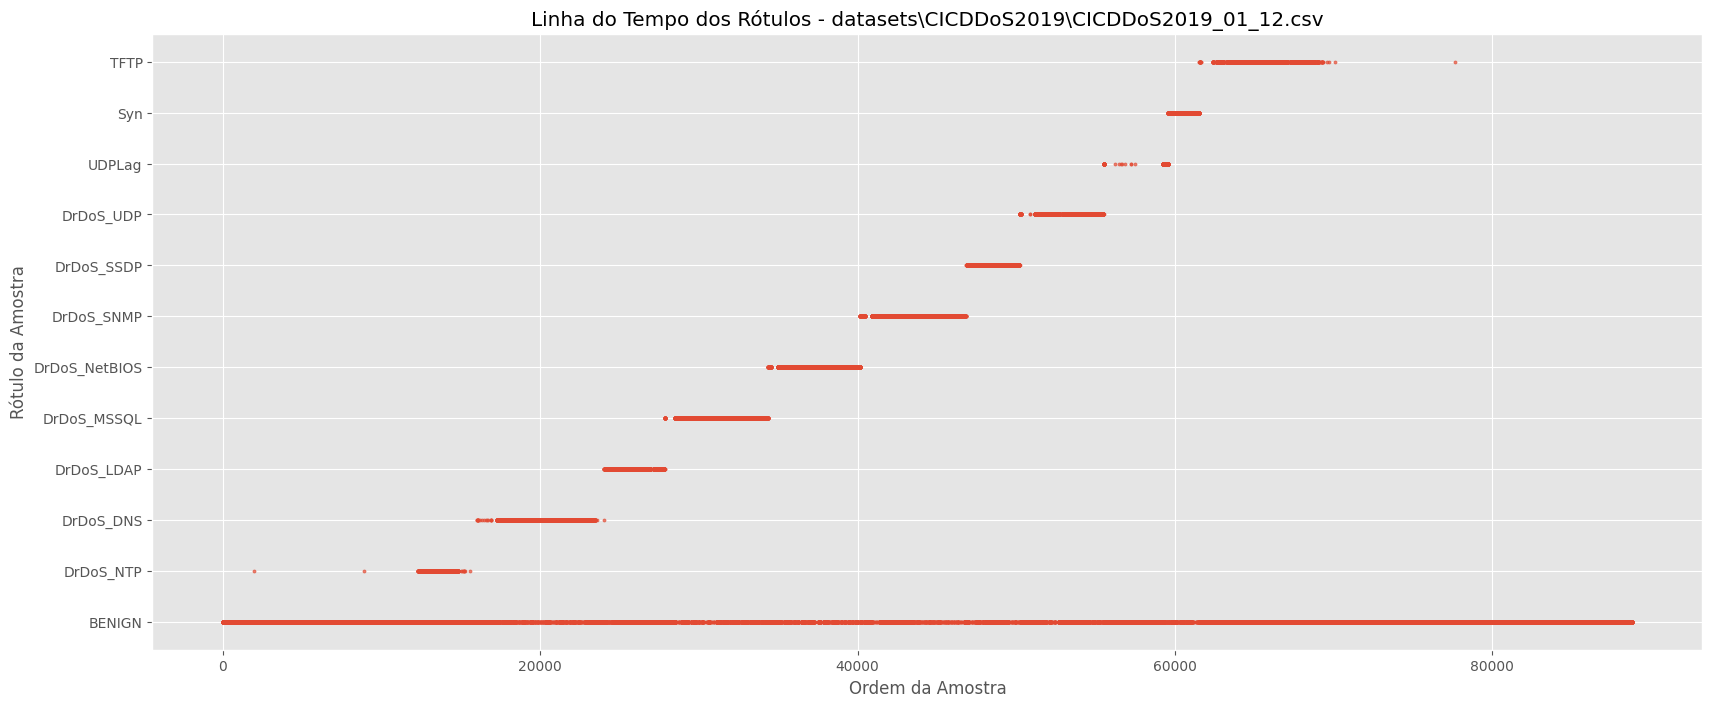

In [2]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Limpar Nomes das Colunas ---
df.columns = df.columns.str.strip()

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()


# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()